# Stellargraph example: Heterogeneous GraphSAGE on the Movielens recommendation dataset

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/hinsage/movielens-recommender.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/hinsage/movielens-recommender.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In this example, we use our generalisation of the [GraphSAGE](http://snap.stanford.edu/graphsage/) algorithm to heterogeneous graphs (which we call HinSAGE) to build a model that predicts user-movie ratings in the Movielens dataset (see below). The problem is treated as a supervised link attribute inference problem on a user-movie network with nodes of two types (users and movies, both attributed) and links corresponding to user-movie ratings, with integer `rating` attributes from 1 to 5 (note that if a user hasn't rated a movie, the corresponding user-movie link does not exist in the network).

To address this problem, we build a model with the following architecture: a two-layer HinSAGE model that takes labeled `(user, movie)` node pairs corresponding to user-movie ratings, and outputs a pair of node embeddings for the `user` and `movie` nodes of the pair. These embeddings are then fed into a link regression layer, which applies a binary operator to those node embeddings (e.g., concatenating them) to construct the link embedding. Thus obtained link embeddings are passed through the link regression layer to obtain predicted user-movie ratings. The entire model is trained end-to-end by minimizing the loss function of choice (e.g., root mean square error between predicted and true ratings) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of user-movie training links fed into the model.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.0.0rc1

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.0.0rc1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.0.0rc1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

Specify the minibatch size (number of user-movie links per minibatch) and the number of epochs for training the ML model:

In [4]:
batch_size = 200
epochs = 20
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

### Load the dataset

In [5]:
dataset = datasets.MovieLens()
display(HTML(dataset.description))
G, edges_with_ratings = dataset.load()

In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2625, Edges: 100000

 Node types:
  movie: [1682]
    Features: float32 vector, length 19
    Edge types: movie-rating->user
  user: [943]
    Features: float32 vector, length 24
    Edge types: user-rating->movie

 Edge types:
    user-rating->movie: [100000]


Split the edges into train and test sets for model training/evaluation:

In [7]:
edges_train, edges_test = model_selection.train_test_split(
    edges_with_ratings, train_size=train_size, test_size=test_size
)

edgelist_train = edges_train[["user_id", "movie_id"]].to_numpy()
edgelist_test = edges_test[["user_id", "movie_id"]].to_numpy()

labels_train = edges_train["rating"]
labels_test = edges_test["rating"]

Our machine learning task of learning user-movie ratings can be framed as a supervised Link Attribute Inference: given a graph of user-movie ratings, we train a model for rating prediction using the ratings edges_train, and evaluate it using the test ratings edges_test. The model also requires the user-movie graph structure, to do the neighbour sampling required by the HinSAGE algorithm.

We create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" user-movie links to the input of HinSAGE: they take minibatches of user-movie links, sample 2-hop subgraphs of G with `(user, movie)` head nodes extracted from those user-movie links, and feed them, together with the corresponding user-movie ratings, to the input layer of the HinSAGE model, for SGD updates of the model parameters.

Specify the sizes of 1- and 2-hop neighbour samples for HinSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the HinSAGE model.

In [8]:
num_samples = [8, 4]

Create the generators to feed data from the graph to the Keras model. We need to specify the nodes types for the user-movie pairs that we will feed to the model. The `shuffle=True` argument is given to the `flow` method to improve training.

In [9]:
generator = HinSAGELinkGenerator(
    G, batch_size, num_samples, head_node_types=["user", "movie"]
)
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)

Build the model by stacking a two-layer HinSAGE model and a link regression layer on top.

First, we define the HinSAGE part of the model, with hidden layer sizes of 32 for both HinSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive `dropout` rate, `0 < dropout < 1`)

Note that the length of `layer_sizes` list must be equal to the length of `num_samples`, as `len(num_samples)` defines the number of hops (layers) in the HinSAGE model.

In [10]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('user', [2]),
 ('movie', [3]),
 ('movie', [4]),
 ('user', [5]),
 ('user', []),
 ('movie', [])]

In [11]:
generator.schema.schema

{'user': [EdgeType(n1='user', rel='rating', n2='movie')],
 'movie': [EdgeType(n1='movie', rel='rating', n2='user')]}

In [12]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)

In [13]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

Add the final estimator layer for predicting the ratings. The edge_embedding_method argument specifies the way in which node representations (node embeddings) are combined into link representations (recall that links represent user-movie ratings, and are thus pairs of (user, movie) nodes). In this example, we will use 'concat', i.e., node embeddings are concatenated to get link embeddings.

In [14]:
# Final estimator layer
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


Create the Keras model, and compile it by specifying the optimizer, loss function to optimise, and metrics for diagnostics:

In [15]:
import tensorflow.keras.backend as K


def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

Summary of the model:

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 19)]      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 24)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32, 19)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1, 24)]      0                                            
______________________________________________________________________________________________

In [17]:
# Specify the number of workers to use for model training
num_workers = 4

Evaluate the fresh (untrained) model on the test set (for reference):

In [18]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
150/150 [==============================] - 18s 123ms/step - loss: 13.1314 - root_mean_square_error: 3.6231 - mean_absolute_error: 3.4458: 12s - loss: 13.0940 - root_ - ETA: 5s - loss: 13.1473 - root_mean_square_error: 3.6252 - mean_ab
Untrained model's Test Evaluation:
	loss: 13.1314
	root_mean_square_error: 3.6231
	mean_absolute_error: 3.4458


Train the model by feeding the data from the graph in minibatches, using mapper_train, and get validation metrics after each epoch:

In [19]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

  ['...']
  ['...']
Train for 350 steps, validate for 150 steps
Epoch 1/20
350/350 [==============================] - 63s 181ms/step - loss: 1.3614 - root_mean_square_error: 1.1402 - mean_absolute_error: 0.9432 - val_loss: 1.1606 - val_root_mean_square_error: 1.0762 - val_mean_absolute_error: 0.8712mean_square_error: 1.1855 - mean_ab - ETA: 17s - lo - ETA: 7s -
Epoch 2/20
350/350 [==============================] - 60s 172ms/step - loss: 1.1558 - root_mean_square_error: 1.0739 - mean_absolute_error: 0.8735 - val_loss: 1.1355 - val_root_mean_square_error: 1.0645 - val_mean_absolute_error: 0.866090 - mea - ETA: 10s - loss: 1.1612 - root_mean_square_error: 1.0763 - mean_abs
Epoch 3/20
350/350 [==============================] - 60s 173ms/step - loss: 1.1367 - root_mean_square_error: 1.0648 - mean_absolute_error: 0.8633 - val_loss: 1.1248 - val_root_mean_square_error: 1.0594 - val_mean_absolute_error: 0.85905 - mean_absolute_err
Epoch 4/20
350/350 [==============================] - 60s 173ms

Plot the training history:

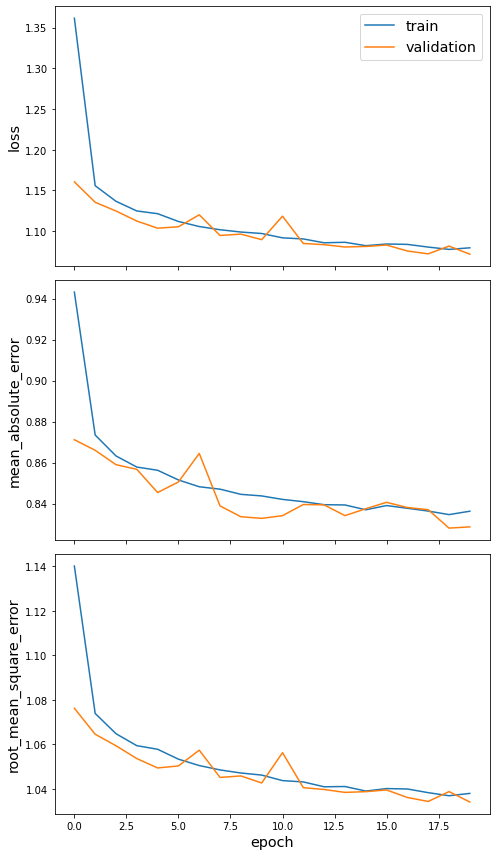

In [20]:
sg.utils.plot_history(history)

Evaluate the trained model on test user-movie rankings:

In [21]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
150/150 [==============================] - 18s 119ms/step - loss: 1.0715 - root_mean_square_error: 1.0339 - mean_absolute_error: 0.8291s - loss: 1.0638 
Test Evaluation:
	loss: 1.0715
	root_mean_square_error: 1.0339
	mean_absolute_error: 0.8291


Compare the predicted test rankings with "mean baseline" rankings, to see how much better our model does compared to this (very simplistic) baseline:

In [22]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.1202962921576745
	mean_absolute_error =  0.9403507492701213

Model Test set metrics:
	root_mean_square_error =  1.0356725718073565
	mean_absolute_error =  0.8285433219174544


Compare the distributions of predicted and true rankings for the test set:

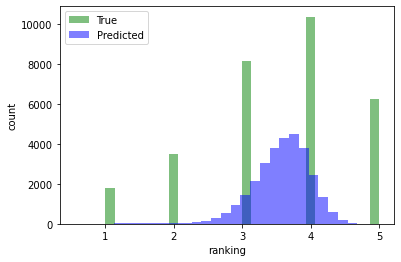

In [23]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

We see that our model beats the "mean baseline" by a significant margin. To further improve the model, you can try increasing the number of training epochs, change the dropout rate, change the sample sizes for subgraph sampling `num_samples`, hidden layer sizes `layer_sizes` of the HinSAGE part of the model, or try increasing the number of HinSAGE layers.

However, note that the distribution of predicted scores is still very narrow, and rarely gives 1, 2 or 5 as a score.

This model uses a bipartite user-movie graph to learn to predict movie ratings. It can be further enhanced by using additional relations, e.g., friendships between users, if they become available. And the best part is: the underlying algorithm of the model does not need to change at all to take these extra relations into account - all that changes is the graph that it learns from!

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/hinsage/movielens-recommender.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/hinsage/movielens-recommender.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>